In [8]:
import poliastro as PA
import numpy as np
import matplotlib.pyplot as plt
import time as time_pkg

from astropy import units as u

from poliastro.bodies import Earth, Body
from poliastro.twobody import Orbit

from scipy.stats import expon, uniform, norm, triang
from scipy.special import comb

from lib.GPUKeplerSimulation import propagate, average_scaler, average_3vector
from lib.DisplaySimulation import displaySimulation

In [9]:
class AsteriodBelt:
    size = 0
    micro = 1*u.km**3/u.s**2
    a = np.array([])*u.km
    ecc = np.array([])*u.one
    inc = np.array([])*u.rad
    Omega = np.array([])*u.rad
    w = np.array([])*u.rad
    M = np.array([])*u.rad
    def __init__(self, _size, _micro, _a, _ecc, _inc, _Omega, _w, _M):
        self.size = _size
        self.micro = _micro
        self.a = _a
        self.ecc = _ecc
        self.inc = _inc
        self.Omega = _Omega
        self.w = _w
        self.M = _M
        
    def setMeanAnamoly(self, _M):
        self.M = _M

In [10]:
def dipoleKick(GM, belt, kickStrength):
    unit_r = np.empty(3) 
    newR = np.empty(3)

    orb = [None]*belt.size

    for i in range(0, belt.size):
        orb[i] = Orbit.from_classical(GM, belt.a[i], belt.ecc[i], belt.inc[i], belt.Omega[i], belt.w[i], PA.core.angles.E_to_nu(PA.core.angles.E_to_M(belt.M[i], belt.ecc[i]), belt.ecc[i])*u.rad)

    for i in range(0, belt.size):
            if orb[i].energy >= 0:
                print(orb[i], " is ALREADY not a bound orbit BEFORE KICKING.")
            old_radius = np.linalg.norm(orb[i].r)
            unit_r = orb[i].r/old_radius
            old_r_0 = orb[i].a*(1 - np.square(orb[i].ecc))
            newPosition = orb[i].r + kickStrength*unit_r
            oldThetaVelocity = orb[i].v - np.dot(orb[i].v, unit_r)*unit_r
            newThetaVelocity = old_radius/(old_radius + kickStrength)*oldThetaVelocity
            newVelocity = np.dot(orb[i].v, unit_r)*unit_r + newThetaVelocity
            orb[i] = Orbit.from_vectors(GM, newPosition, newVelocity)
            belt.a[i] = orb[i].a
            belt.ecc[i] = orb[i].ecc
            belt.inc[i] = orb[i].inc
            belt.Omega[i] = orb[i].raan
            belt.w[i] = orb[i].argp
            belt.M[i] = PA.core.angles.E_to_M(PA.core.angles.nu_to_E(orb[i].nu, orb[i].ecc), orb[i].ecc)*u.rad
            new_r_0 = orb[i].a*(1 - np.square(orb[i].ecc))
            if old_r_0 - new_r_0 > 10**-12*u.km:
                print("L_2 before and after do not match: ", old_r_0, "\t", new_r_0)
            if orb[i].energy >= 0:
                print(orb[i], " is not a bound orbit.")
            if (orb[i].r != newPosition).any():
                print("r got missassigned.")
    return belt

def quadrapoleKick(GM, belt, quad_strength, radius_offset):
    unit_r = np.empty(3) 
    newR = np.empty(3)

    orb = [None]*belt.size

    for i in range(0, belt.size):
        orb[i] = Orbit.from_classical(GM, belt.a[i], belt.ecc[i], belt.inc[i], belt.Omega[i], belt.w[i], PA.core.angles.E_to_nu(PA.core.angles.E_to_M(belt.M[i], belt.ecc[i]), belt.ecc[i])*u.rad)

    for i in range(0, belt.size):
            if orb[i].energy >= 0:
                print(orb[i], " is ALREADY not a bound orbit BEFORE KICKING.")
            old_radius = np.linalg.norm(orb[i].r)
            unit_r = orb[i].r/old_radius
            newVelocity = orb[i].v + quad_strength*(old_radius - radius_offset)*unit_r
            orb[i] = Orbit.from_vectors(GM, orb[i].r, newVelocity)
            belt.a[i] = orb[i].a
            belt.ecc[i] = orb[i].ecc
            belt.inc[i] = orb[i].inc
            belt.Omega[i] = orb[i].raan
            belt.w[i] = orb[i].argp
            belt.M[i] = PA.core.angles.E_to_M(PA.core.angles.nu_to_E(orb[i].nu, orb[i].ecc), orb[i].ecc)*u.rad
            if orb[i].energy >= 0:
                print(orb[i], " is not a bound orbit.")
    return belt

In [39]:
def runOneEchoAmplitudeMeasurement(size, r_0, epsilon, k, m, dipoleKickStrength, quadrapoleKickStrength, tau, deltaTau, timestep):
    # Near SHO Distribution
    # Here I'm setting J_SHO = sqrt(ma^3/2k) * (p^2/2m + k/a^3*x^2)
    # This leads to J_SHO = sqrt(ka/2)e^2 = sqrt(k/2)(J_1 - J_2^2/J_1)
    # Then im distributing particles according to exp{- J_SHO/epsilon}

    J_SHO = expon.rvs(scale=epsilon, loc=0, size=size)*1*u.kg*u.km**2/u.s

    #J_2 = expon.norm(scale=sigma_a, loc=r_0, size=size)
    J_2 = np.repeat(np.sqrt(r_0), size)

    J_1 = (J_SHO + np.sqrt(np.power(J_SHO, 2) + 4*k*m*np.power(J_2, 2)))/(2.0*np.sqrt(k*m))
    J_3 = J_2

    M = uniform.rvs(loc = -2*np.pi, scale = 2*np.pi, size=size) * u.rad
    w = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
    Omega = np.repeat(0.0, size) * u.rad

    a = np.square(J_1)
    ecc = np.sqrt(1 - np.square(J_2/J_1)) * u.one
    inc = np.arccos(J_3/J_2)

    GM = Body(None, k/m, "Central Body")

    belt = AsteriodBelt(size, k/m, a, ecc, inc, Omega, w, M)

    tau = 1000*u.second

    belt = dipoleKick(GM, belt, dipoleKickStrength)

    radiuses, velocities, final_mean_anamoly = propagate(belt, tau, tau/2)
    belt.setMeanAnamoly(final_mean_anamoly)

    belt = quadrapoleKick(GM, belt, quadrapoleKickStrength, r_0)

    radiuses, velocities, final_mean_anamoly = propagate(belt, tau-deltaTau, (tau-deltaTau)/2)
    belt.setMeanAnamoly(final_mean_anamoly)

    radiuses, velocities, final_mean_anamoly = propagate(belt, 2*deltaTau, timestep)

    avr_radius = average_scaler(radiuses)

    avr_radius_diviation = np.absolute(avr_radius - r_0)

    echoAmp = max(avr_radius_diviation)

    echoIndex = np.argmax(avr_radius_diviation)

    return echoAmp, echoIndex*timestep + tau-deltaTau, avr_radius


In [40]:
deltaTau = 300*u.second
timestep = 0.1*u.second
echoAmp, echoTime, avr_radius = runOneEchoAmplitudeMeasurement(20000, 0.05*u.km, 0.0000001*u.kg*u.km**2/u.s, 0.00112*u.kg*u.km**3/u.s**2, 0.1*u.kg, 0.001*u.km, 0.35 * u.second**-1, 1000*u.second, deltaTau, timestep)

GPU memory size:  6871580672
Running  1  memory frames
GPU memory size:  6871580672
Running  1  memory frames
GPU memory size:  6871580672
Running  12  memory frames


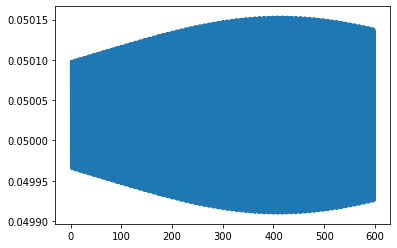

In [41]:
time = np.linspace(0.0*u.second, 2*deltaTau, int(2*deltaTau/timestep))
plt.plot(time, avr_radius)